# Optimization For Data Science - Project

Testing ADMM methods on House Prices dataset

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data?select=train.csv

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import random


%matplotlib inline

<h1> Import and Preprocess Data

In [143]:
df = pd.read_csv('https://raw.githubusercontent.com/ktran16/datasets/master/train_houseprice.csv')
display(df.head())
display(df.shape)
display(df.columns)

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


(2051, 81)

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [144]:
# clean column names
def clean_columns(col):
    return col.lower().replace(' ', '_').replace('/', '_')

df.columns = [clean_columns(col) for col in df.columns]

In [123]:
display(df.columns[df.isnull().any()])
display(df[df.columns[df.isnull().any()]].isnull().sum())

Index(['lot_frontage', 'alley', 'mas_vnr_type', 'mas_vnr_area', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'bsmt_full_bath', 'bsmt_half_bath', 'fireplace_qu', 'garage_type',
       'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area',
       'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature'],
      dtype='object')

lot_frontage       330
alley             1911
mas_vnr_type        22
mas_vnr_area        22
bsmt_qual           55
bsmt_cond           55
bsmt_exposure       58
bsmtfin_type_1      55
bsmtfin_sf_1         1
bsmtfin_type_2      56
bsmtfin_sf_2         1
bsmt_unf_sf          1
total_bsmt_sf        1
bsmt_full_bath       2
bsmt_half_bath       2
fireplace_qu      1000
garage_type        113
garage_yr_blt      114
garage_finish      114
garage_cars          1
garage_area          1
garage_qual        114
garage_cond        114
pool_qc           2042
fence             1651
misc_feature      1986
dtype: int64

In [145]:
# functions to handle missing values
def fill_na_with_mean_or_mode(col):
    if col.dtype == int or col.dtype == float:
        return col.fillna(round(col.mean()), inplace=True)
    else:
        return col.fillna(col.mode()[0], inplace=True)
        
def make_string_na(col):
        return col.fillna('NA', inplace=True)

In [146]:
# handling missing values
[fill_na_with_mean_or_mode(df[col]) for col in ['lot_frontage', 'mas_vnr_area','garage_cars', 'garage_area']]

[make_string_na(df[col]) for col in ['alley', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'pool_qc', 'fence', 'misc_feature', 'mas_vnr_type']]

[df[col].fillna(0, inplace=True) for col in ['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'bsmt_full_bath', 'bsmt_half_bath']]

df.garage_yr_blt.fillna(df.year_built, inplace=True)

df.garage_yr_blt[1699] = 2007

In [147]:
df[df.columns[df.isnull().any()]].isnull().sum()

Series([], dtype: float64)

In [148]:
df.saleprice[df.saleprice < 0]

Series([], Name: saleprice, dtype: int64)

In [149]:
# applied a permanent log transformation to target variable
df.saleprice = df.saleprice.map(np.log)


In [150]:
df.dtypes.value_counts()


object     42
int64      27
float64    12
dtype: int64

In [151]:
df.columns[df.dtypes == object]


Index(['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour',
       'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc',
       'central_air', 'electrical', 'kitchen_qual', 'functional',
       'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual',
       'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature',
       'sale_type'],
      dtype='object')

In [155]:
to_dummy = ['ms_zoning', 'street', 'alley', 'lot_shape', 'land_contour',
       'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl',
       'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc',
       'central_air', 'electrical', 'kitchen_qual', 'functional',
       'fireplace_qu', 'garage_type', 'garage_finish', 'garage_qual',
       'garage_cond', 'paved_drive', 'pool_qc', 'fence', 'misc_feature',
       'sale_type']

In [153]:
df = pd.get_dummies(df, columns=to_dummy, drop_first=True)


In [154]:
df.dtypes.value_counts()

uint8      226
int64       27
float64     12
dtype: int64

In [156]:
df.shape


(2051, 265)

# Implement ADMM methods


In [157]:
import admm_lasso as al 
import oadmm_lasso as oal 
import fobosADMM_lasso as fal 
import stochasticADMM_lasso as sal 
from importlib import reload

reload(al)


%matplotlib inline
plt.style.use('seaborn-white')

In [158]:
numerical_columns = df._get_numeric_data().columns
features = [col for col in numerical_columns if col != 'saleprice']
A = df[features].values
b = df.saleprice.values
b = np.atleast_2d(b).T

convert = preprocessing.StandardScaler()
A_n = convert.fit_transform(A)

display(A_n.shape, b.shape)

(2051, 264)

(2051, 1)

<h2> Normal ADMM

In [159]:
###############################
# initialize global parameters:
###############################

lamda = 0.05

rho = 1.0
rel_par = 1.0
max_iters = 100
abstol = 1e-3
reltol = 1e-2

In [160]:
x, h = al.admm_lasso(A_n, b, lamda, rho, rel_par, max_iters, abstol, reltol)

Text(0.5, 0, 'iter (k)')

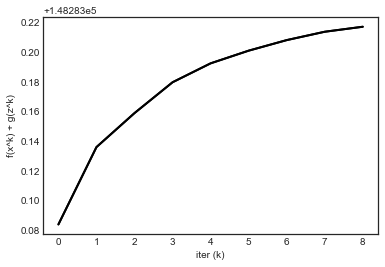

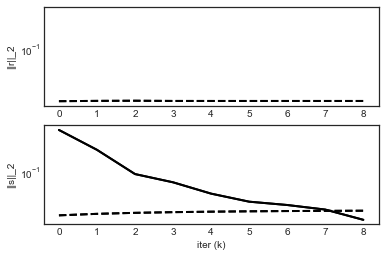

In [161]:
K = len(h['obj_val'][np.where(h['obj_val']!=0)])

fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.plot(np.arange(K), h['obj_val'][:K],'k', ms=10, lw=2)
ax.set_ylabel('f(x^k) + g(z^k)')
ax.set_xlabel('iter (k)')

fig2 = plt.figure(2)
ax1 = fig2.add_subplot(211)
ax1.semilogy(np.arange(K), np.maximum(1e-8, h['r_norm'][:K]),' k',lw=2)
ax1.semilogy(np.arange(K), h['eps_pri'][:K], 'k--', lw=2)
ax1.set_ylabel('||r||_2')

ax2 = fig2.add_subplot(212)
ax2.semilogy(np.arange(K), np.maximum(1e-8,h['s_norm'][:K]), 'k', lw=2)
ax2.semilogy(np.arange(K), h['eps_dual'][:K], 'k--',lw=2)
ax2.set_ylabel('||s||_2')
ax2.set_xlabel('iter (k)')
K = len(h['obj_val'][np.where(h['obj_val']!=0)])

fig1 = plt.figure(1)
ax = fig1.add_subplot(111)
ax.plot(np.arange(K), h['obj_val'][:K],'k', ms=10, lw=2)
ax.set_ylabel('f(x^k) + g(z^k)')
ax.set_xlabel('iter (k)')

fig2 = plt.figure(2)
ax1 = fig2.add_subplot(211)
ax1.semilogy(np.arange(K), np.maximum(1e-8, h['r_norm'][:K]),' k',lw=2)
ax1.semilogy(np.arange(K), h['eps_pri'][:K], 'k--', lw=2)
ax1.set_ylabel('||r||_2')

ax2 = fig2.add_subplot(212)
ax2.semilogy(np.arange(K), np.maximum(1e-8,h['s_norm'][:K]), 'k', lw=2)
ax2.semilogy(np.arange(K), h['eps_dual'][:K], 'k--',lw=2)
ax2.set_ylabel('||s||_2')
ax2.set_xlabel('iter (k)')
